# Задание **Ultra Lite**

Используя шаблон ноутбука, напишите загрузку данных и распознавание стилей музыки с помощью Dense сети. 

Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками

# Подключение библиотек и дополнительных функций

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from google.colab import drive, files
import IPython.display as ipd

import librosa
import librosa.display
import os
import numpy as np
import pandas as pd
import sklearn
import time
from math import sqrt

import matplotlib.pyplot as plt


In [ ]:
# Подключение гугл диска
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Функция параметризации аудио
def get_features(y,sr):
  '''
  ВХОДНЫЕ ДАННЫЕ:
    y - файл(музыкальный)
    sr - Sample Rate(частота дискритизации)

  ПЕРЕМЕНЫЕ:
    chroma_stft - Частота цветности (по умолчанию 12 баков цветности)
    mfcc        - Мел кепстральные коэффициенты (по умолчанию 20)
    rmse        - Среднеквадратичная амплитуда
    spec_cent   - Среднее спектрального центроида
    spec_bw     - Среднее ширины полосы частот
    rolloff     - Среднее спектрального спада частоты
    zcr         - Среднее частоты пересечения нуля звукового временного ряда

  ВЫХОД:
    out - Результирующий список (numpy массив, вектор из 37 значений)
  '''
  # Получение различных параметров аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) 
  mfcc = librosa.feature.mfcc(y=y, sr=sr)

  # Получение средних значений
  rmse = np.mean(librosa.feature.rms(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))

  # Добавление всех параметров в один список
  
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)

  # С помощью цикла добавляем среднее всех спектральных Мел коэффициентов (20 значений)
  for i in mfcc:
    out.append(np.mean(i))
  
  # С помощью цикла добавляем среднее всех частот цветности (12 значений)
  for i in chroma_stft:
    out.append(np.mean(i))

  # Возрат получившегося списка
  return out

In [ ]:
# Функция вывода summary и схемы нейронной сети
def showModel(model):
  model.summary()
  print("\n\n")
  return plot_model(model, dpi=50, show_shapes=True)

In [ ]:
# Функция вывода графиков
def chart(hist):
  plt.plot(hist.history["accuracy"], label="Точность на обучающей выборке")
  plt.plot(hist.history["val_accuracy"], label="Точность на проверочной выборке")
  plt.xlabel("Эпоха обучения")
  plt.ylabel("Точность")

  plt.plot(hist.history["loss"], label="Ошибка на обучающей выборке")
  plt.plot(hist.history["val_loss"], label="Ошибка на проверочной выборке")
  plt.xlabel("Эпоха обучения")
  plt.ylabel("Ошибка")

  plt.grid()
  plt.legend()
  plt.show()

In [ ]:
# Функция для сохранения результата обучения. С последующей записью в таблицу pandas. 
def table(hist):
  dct = []
  # В цикле проходимся по всем значениям из history  
  for i in hist.history.values():
    dct.append(i)                           # Результат выгружаются в словарь.
  result = np.array(dct)                    # Переводим в numpy массив. 
  return result 

In [ ]:
# Создадим таблицу pandas
df = pd.DataFrame(columns = ["Кол-во слоев", "Кол-во эпох", "Оптимайзер", "loss", "accuracy", "val_loss", "val_accuracy"])

# Подготовка данных

In [ ]:
# Распаковка архива
!unzip -q '/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/genres.zip'

# получаем список файлов в распакованной папке
genres = os.listdir('genres')

# Проверка
print("В genres находятся папки:")
!ls genres

# B одну из папок
print("\nВ папке rock находятся файлы:")
!ls genres/rock


В genres находятся папки:
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock

В папке rock находятся файлы:
rock.00000.au  rock.00020.au  rock.00040.au  rock.00060.au  rock.00080.au
rock.00001.au  rock.00021.au  rock.00041.au  rock.00061.au  rock.00081.au
rock.00002.au  rock.00022.au  rock.00042.au  rock.00062.au  rock.00082.au
rock.00003.au  rock.00023.au  rock.00043.au  rock.00063.au  rock.00083.au
rock.00004.au  rock.00024.au  rock.00044.au  rock.00064.au  rock.00084.au
rock.00005.au  rock.00025.au  rock.00045.au  rock.00065.au  rock.00085.au
rock.00006.au  rock.00026.au  rock.00046.au  rock.00066.au  rock.00086.au
rock.00007.au  rock.00027.au  rock.00047.au  rock.00067.au  rock.00087.au
rock.00008.au  rock.00028.au  rock.00048.au  rock.00068.au  rock.00088.au
rock.00009.au  rock.00029.au  rock.00049.au  rock.00069.au  rock.00089.au
rock.00010.au  rock.00030.au  rock.00050.au  rock.00070.au  rock.00090.au
rock.00011.au  rock.00031.au  rock.00051.au  rock.00071.a

In [ ]:
# Кол-во папок
print(len(genres))

10


# Визуализация одной композиции

Возьмем 10ый файл из папки классической музыки

In [ ]:
audio_classical = 'genres/classical/classical.00010.au'
x, sr = librosa.load(audio_classical)
# Выводим данные по композиции
print(type(x), type(sr))
print(x.shape, sr)
print(x.shape[0]/sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050
30.013333333333332


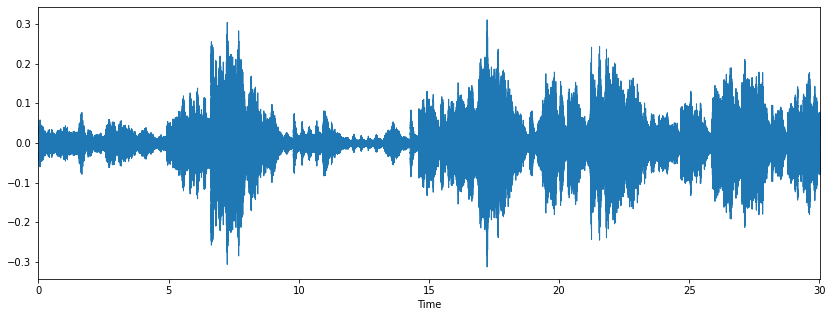

In [ ]:
# Выводим сигнал на экран 
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sr)  # Амплитуда
plt.show()

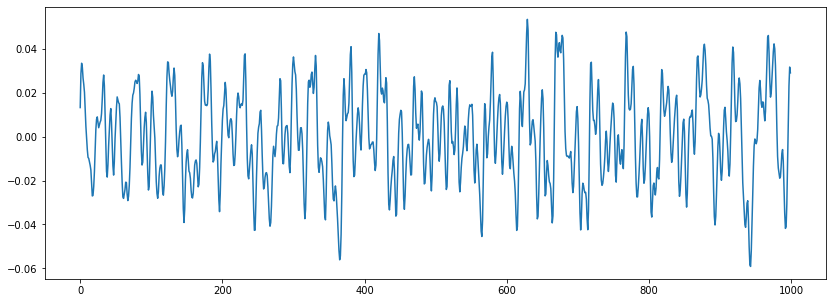

In [ ]:
# Первые 1000 значений сигнала
plt.figure(figsize=(14,5))
plt.plot(x[:1000])
plt.show()

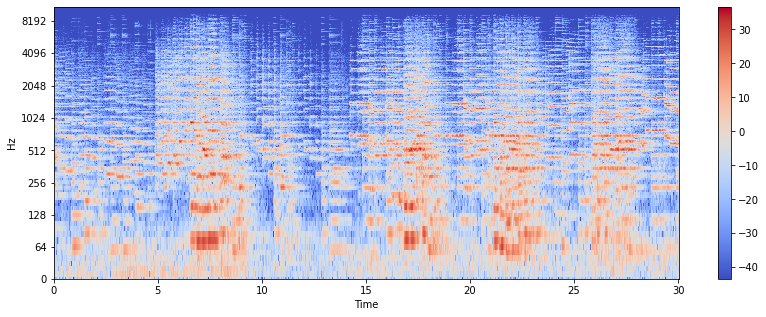

In [ ]:
# Вычисляем спектр сигнала
X = librosa.stft(x)

# Переводим формат спектра в амплитуду
Xdb = librosa.amplitude_to_db(abs(X))   # Меняем шкалу на децибелы(для удобного отображения)

#Выводим спектрограмму на экран
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

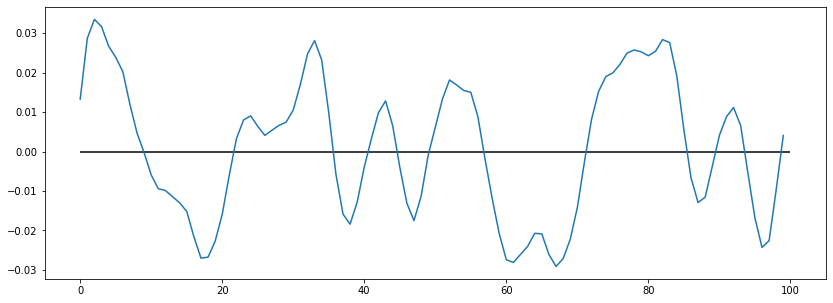

In [ ]:
n0 = 0                         # Задаём начальную точку отображения
n1 = 100                       # Задаём конечную точку отображения

#Отображаем сигнал
plt.figure(figsize=(14, 5))  
plt.plot(x[n0:n1])            # От начальной до конечной точки
plt.hlines(0, 0, 100)
plt.grid(which='minor', color = 'gray', linestyle = ':')
plt.show() 

In [ ]:
# Раcчитываем пересечения нуля
zero_crossings = librosa.zero_crossings(x, pad=False)
print(sum(zero_crossings)) # Суммарное количество пересечений
print(zero_crossings)      # Наличие пересечения в каждой точке

57150
[False False False ... False False False]


(661794,)


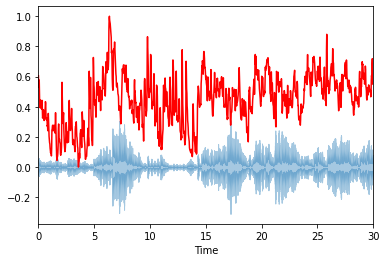

In [ ]:
# Вычисляем спектральный центроид
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(x.shape)

#Вычисляем времени для визуализации
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Строим график сигнала и спектрального центроида
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

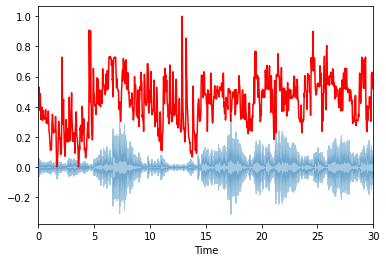

In [ ]:
# Спектральный спад частоты
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.85)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

(20, 1293)


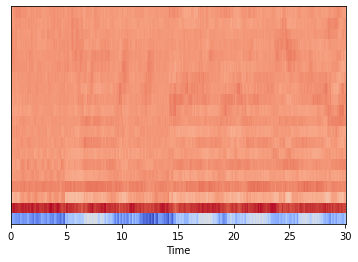

In [ ]:
# Мел-частотные кепстральные коэффициенты
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()                             

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


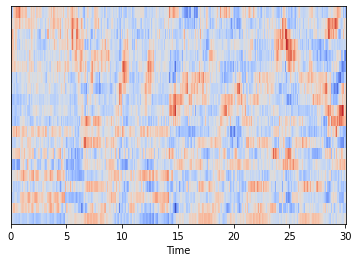

In [ ]:
# Нормируем Мел коэффициенты
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()  


(12, 1293)


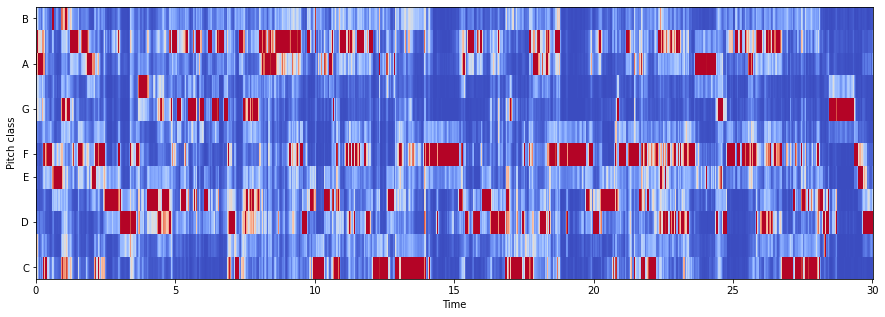

In [ ]:
# Частота цветности

hop_length = 512  # Задаём размер отрезка сигнала
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length = hop_length)
print(chromagram.shape)
plt.figure(figsize=(15,5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length = hop_length, cmap='coolwarm')
plt.show()

# Формирование выборок

In [ ]:
# Формирование обучающей выборки
xTrain = []
yTrain=[]

# Циклом проходим по всем жанрам
for i in range(len(genres)):                                   
  curr_time = time.time()                                      # Сохраняем время старта
  g = genres[i]                                                # Берем текущий жанр
  for filename in os.listdir(f'genres/{g}'):                   # Проходим по файлам папки, соответствующей текущему жанру
    songname = f'./genres/{g}/{filename}'                      # Получаем имя песни
    y , sr = librosa.load(songname, mono=True, duration=30)    # Загружаем аудиосигнал в переменную y. Используем первые 30 секунд аудио
    out = get_features(y, sr)                                  # Превращаем сигнал в параметризованные данные
    xTrain.append(out)                                         # Добавляем строку в xTrain 
    yTrain.append(to_categorical(i, len(genres)))              # Добавляем в yTrain номер жанра в формате ohe
  
  print("Жанр ", g, " готов за ", round(time.time()- curr_time), "с", sep="")

Жанр classical готов за 47с
Жанр hiphop готов за 46с
Жанр pop готов за 46с
Жанр country готов за 45с
Жанр disco готов за 46с
Жанр reggae готов за 45с
Жанр jazz готов за 45с
Жанр rock готов за 45с
Жанр blues готов за 45с
Жанр metal готов за 45с


In [ ]:
# Обучающую выборку переводим в numpy массивы
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

In [ ]:
# Создаём backup обучающей выборки
xTrain_backup = xTrain.copy()
yTrain_backup = yTrain.copy()

In [ ]:
# И сохраняем numpy массивы на гугл диск. Чтобы в дальнейшем не создавать заного выборки. Так как создаются они долго
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTrain', xTrain)
# np.save('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTrain', yTrain)

In [ ]:
# Раскомментировать если нужно загрузить готовые выборки из гугл диска
# xTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/xTrain.npy')
# yTrain = np.load('/content/drive/MyDrive/УИИ/Обработка аудио/База для аудио GENRES.ZIP/yTrain.npy')

In [ ]:
# Проверим yTrain
yTrain_class = np.argmax(yTrain, axis=1)
print(yTrain_class)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
np.argmax(yTrain, axis=0)


array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [ ]:
# Посмотрим на размеры
print(xTrain.shape)
print(yTrain.shape)
print(yTrain_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
# Нормируем данные
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
print(xTrain[0])   # Проверка

[-1.32663925 -1.38419977 -1.71990323 -1.56736069 -0.78199909 -1.61973069
  1.70391788 -0.86093445 -1.19907376 -0.16454077 -1.99137642 -0.02974732
 -1.9022879  -0.01379469 -0.93735365  1.01113134  0.14005283  2.10624479
  0.48299431  1.21665707  0.41187721  0.78726175 -0.85881748 -0.15326211
  0.63318674  0.40619155 -1.76526582 -0.86190039 -1.87667659 -1.60605199
  0.7560256  -1.90841092 -2.38172355 -2.69509296 -1.76119404 -1.15186775
 -1.79156463]


In [ ]:
# Разделение на обучающую и проверочные выборки
xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain_class, test_size=0.1)    # Выборка маленкая, поэтому на тест 10%
# B сразу выведем размеры
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(900, 37)
(900,)
(100, 37)
(100,)


# Нейронные сети

## Нейронная сеть с Dense слоями (все параметры)



In [ ]:
indexes = range(37)   # #Указываем, какие индексы данных во входных векторах брать для обучения

In [ ]:
# Создание сети
modelD_37 =  Sequential()
modelD_37.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
modelD_37.add(Dense(128, activation='elu'))
modelD_37.add(Dense(64, activation='elu'))
modelD_37.add(Dense(32, activation='elu'))
modelD_37.add(Dense(len(genres), activation='softmax'))

modelD_37.compile(optimizer=RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               9728      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 53,290
Trainable params: 53,290
Non-trainable params: 0
_________________________________________________________________





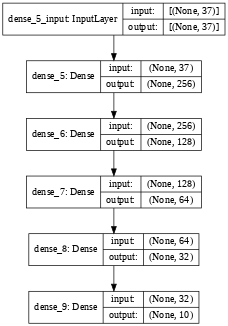

In [ ]:
showModel(modelD_37)

### Обучение

In [ ]:
historyD_37 = modelD_37.fit(xTrain[:, indexes], yTrain, epochs=200, batch_size=20, validation_data=(xTest[:,indexes], yTest))

Epoch 1/200
45/45 [==============================] - 1s 6ms/step - loss: 2.0207 - accuracy: 0.2900 - val_loss: 1.8014 - val_accuracy: 0.3600
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 1.7300 - accuracy: 0.3800 - val_loss: 1.6501 - val_accuracy: 0.4200
Epoch 3/200
45/45 [==============================] - 0s 2ms/step - loss: 1.5920 - accuracy: 0.4344 - val_loss: 1.5640 - val_accuracy: 0.4300
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 1.4954 - accuracy: 0.4944 - val_loss: 1.4916 - val_accuracy: 0.4800
Epoch 5/200
45/45 [==============================] - 0s 2ms/step - loss: 1.4196 - accuracy: 0.5300 - val_loss: 1.4446 - val_accuracy: 0.5000
Epoch 6/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3573 - accuracy: 0.5444 - val_loss: 1.4025 - val_accuracy: 0.4900
Epoch 7/200
45/45 [==============================] - 0s 2ms/step - loss: 1.3035 - accuracy: 0.5678 - val_loss: 1.3605 - val_accuracy: 0.5300
Epoch 8/200
4

### График

In [ ]:
historyD_37.history

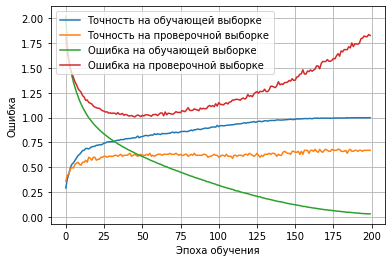

In [ ]:
chart(historyD_37)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD_37 = table(historyD_37)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(Полные данные)'] = ['5', '200', 'RMSprop', min(resultD_37[0]), max(resultD_37[1]), min(resultD_37[2]), max(resultD_37[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68


## Нейронная сеть Dense 2 слоя(все параметры)

In [ ]:
modelD2_37 = Sequential()
modelD2_37.add(Dense(200, activation='elu', input_shape=(len(indexes),)))
modelD2_37.add(Dense(10, activation='softmax'))

modelD2_37.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 200)               7600      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2010      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________





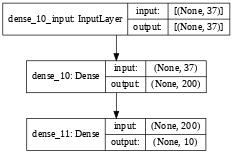

In [ ]:
showModel(modelD2_37)

### Обучение

In [ ]:
historyD2_37 = modelD2_37.fit(xTrain[:,indexes], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes], yTest))

Epoch 1/120
45/45 [==============================] - 0s 4ms/step - loss: 2.4012 - accuracy: 0.1344 - val_loss: 2.2798 - val_accuracy: 0.1000
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0976 - accuracy: 0.2478 - val_loss: 2.0257 - val_accuracy: 0.2400
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9081 - accuracy: 0.3067 - val_loss: 1.8637 - val_accuracy: 0.3200
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7840 - accuracy: 0.3467 - val_loss: 1.7566 - val_accuracy: 0.3400
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6979 - accuracy: 0.3778 - val_loss: 1.6822 - val_accuracy: 0.3900
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6316 - accuracy: 0.4144 - val_loss: 1.6247 - val_accuracy: 0.4100
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.5789 - accuracy: 0.4222 - val_loss: 1.5821 - val_accuracy: 0.4300
Epoch 8/120
4

### График

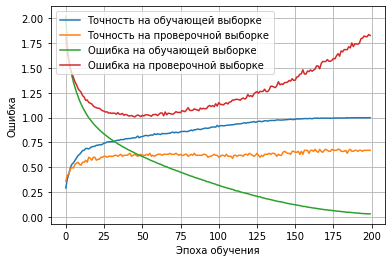

In [ ]:
chart(historyD_37)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_37 = table(historyD2_37)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(Полные данные, 2 слоя)'] = ['2', '120', 'Adam', min(resultD2_37[0]), max(resultD2_37[1]), min(resultD2_37[2]), max(resultD2_37[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60


## Два Dense слоя (кроме Мел коэффициентов и частоты цветности)

In [ ]:
# Выбираем все параметризации, кроме Мел коэффициентов и частоты цветности
indexes_0_5=range(0,5)

modelD2_5 = Sequential()
modelD2_5.add(Dense(200, activation='elu', input_shape=(len(indexes_0_5),)))
modelD2_5.add(Dense(10, activation='softmax'))

modelD2_5.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Вывод summary и схемы нейронной сети

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 200)               1200      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2010      
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________





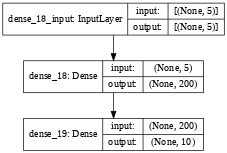

In [ ]:
showModel(modelD2_5)

### Обучение

In [ ]:
historyD2_5 = modelD2_5.fit(xTrain[:,indexes_0_5], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_0_5], yTest) )

Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.2487 - accuracy: 0.0878 - val_loss: 2.1705 - val_accuracy: 0.1100
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1724 - accuracy: 0.1733 - val_loss: 2.0816 - val_accuracy: 0.2300
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1146 - accuracy: 0.2533 - val_loss: 2.0118 - val_accuracy: 0.3100
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0693 - accuracy: 0.2856 - val_loss: 1.9569 - val_accuracy: 0.3100
Epoch 5/120
45/45 [==============================] - 0s 1ms/step - loss: 2.0332 - accuracy: 0.2944 - val_loss: 1.9138 - val_accuracy: 0.3300
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0044 - accuracy: 0.3044 - val_loss: 1.8779 - val_accuracy: 0.3400
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9792 - accuracy: 0.3133 - val_loss: 1.8469 - val_accuracy: 0.3500
Epoch 8/120
4

### График

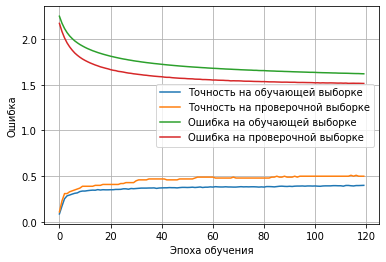

In [ ]:
chart(historyD2_5)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_5 = table(historyD2_5)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(кроме Мел коэффициентов и частоты цветности)'] = ['2', '120', 'Adam', min(resultD2_5[0]), max(resultD2_5[1]), min(resultD2_5[2]), max(resultD2_5[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51


## Два Dense слоя (только Мел коэффициенты)

In [ ]:
indexes_5_25 = range(5,25)

modelD2_5_25 = Sequential()
modelD2_5_25.add(Dense(200, activation='elu', input_shape=(len(indexes_5_25), )))
modelD2_5_25.add(Dense(10, activation='softmax'))

modelD2_5_25.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 200)               4200      
_________________________________________________________________
dense_25 (Dense)             (None, 10)                2010      
Total params: 6,210
Trainable params: 6,210
Non-trainable params: 0
_________________________________________________________________





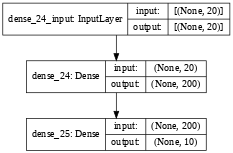

In [ ]:
showModel(modelD2_5_25)

### Обучение

In [ ]:
historyD2_5_25 = modelD2_5_25.fit(xTrain[:,indexes_5_25], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_5_25], yTest) )

Epoch 1/120
45/45 [==============================] - 1s 4ms/step - loss: 2.1599 - accuracy: 0.2056 - val_loss: 2.1036 - val_accuracy: 0.2000
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0285 - accuracy: 0.2700 - val_loss: 1.9885 - val_accuracy: 0.2700
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9366 - accuracy: 0.3089 - val_loss: 1.9012 - val_accuracy: 0.2700
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8668 - accuracy: 0.3278 - val_loss: 1.8327 - val_accuracy: 0.3000
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8108 - accuracy: 0.3511 - val_loss: 1.7822 - val_accuracy: 0.3400
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7655 - accuracy: 0.3656 - val_loss: 1.7376 - val_accuracy: 0.3700
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7250 - accuracy: 0.3800 - val_loss: 1.6988 - val_accuracy: 0.3800
Epoch 8/120
4

### График

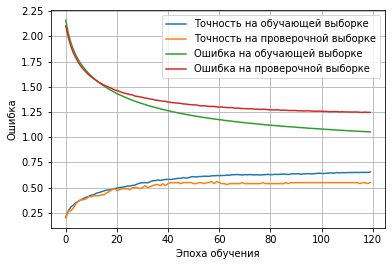

In [ ]:
chart(historyD2_5_25)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_5_25 = table(historyD2_5_25)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(только Мел коэффициенты)'] = ['2', '120', 'Adam', min(resultD2_5_25[0]), max(resultD2_5_25[1]), min(resultD2_5_25[2]), max(resultD2_5_25[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56


## Два Dense слоя (только Частота цветности)

In [ ]:
indexes_25_37 = range(25,37)

modelD2_25_37 = Sequential()
modelD2_25_37.add(Dense(200, activation='elu', input_shape=(len(indexes_25_37), )))
modelD2_25_37.add(Dense(10, activation='softmax'))

modelD2_25_37.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 200)               2600      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                2010      
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________





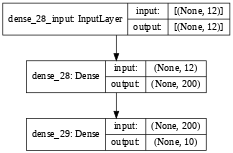

In [ ]:
showModel(modelD2_25_37)

### Обучение

In [ ]:
historyD2_25_37 = modelD2_25_37.fit(xTrain[:,indexes_25_37], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_25_37], yTest) )

Epoch 1/120
45/45 [==============================] - 1s 5ms/step - loss: 2.2913 - accuracy: 0.1456 - val_loss: 2.2103 - val_accuracy: 0.2100
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.1638 - accuracy: 0.2011 - val_loss: 2.1032 - val_accuracy: 0.2600
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0791 - accuracy: 0.2322 - val_loss: 2.0352 - val_accuracy: 0.2700
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0190 - accuracy: 0.2522 - val_loss: 1.9946 - val_accuracy: 0.2900
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9769 - accuracy: 0.2678 - val_loss: 1.9636 - val_accuracy: 0.3000
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9452 - accuracy: 0.2711 - val_loss: 1.9421 - val_accuracy: 0.3000
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9203 - accuracy: 0.2767 - val_loss: 1.9232 - val_accuracy: 0.3100
Epoch 8/120
4

### График

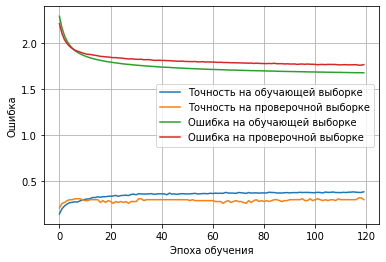

In [ ]:
chart(historyD2_25_37)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_25_37 = table(historyD2_25_37)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(только Частота цветности)'] = ['2', '120', 'Adam', min(resultD2_25_37[0]), max(resultD2_25_37[1]), min(resultD2_25_37[2]), max(resultD2_25_37[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32


## Два Dense слоя (Мел спектральные коэффициенты и частоты цветности)

In [ ]:
indexes_5_37 = range(5,37)

modelD2_5_37 = Sequential()
modelD2_5_37.add(Dense(200, activation='elu', input_shape=(len(indexes_5_37),)))
modelD2_5_37.add(Dense(10, activation='softmax'))
modelD2_5_37.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               6600      
_________________________________________________________________
dense_31 (Dense)             (None, 10)                2010      
Total params: 8,610
Trainable params: 8,610
Non-trainable params: 0
_________________________________________________________________





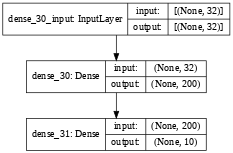

In [ ]:
showModel(modelD2_5_37)

### Обучение

In [ ]:
hisoryD2_5_37 = modelD2_5_37.fit(xTrain[:,indexes_5_37], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_5_37], yTest))

Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.3051 - accuracy: 0.1322 - val_loss: 2.1804 - val_accuracy: 0.1900
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0699 - accuracy: 0.2500 - val_loss: 1.9844 - val_accuracy: 0.2900
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9156 - accuracy: 0.3222 - val_loss: 1.8607 - val_accuracy: 0.3300
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8071 - accuracy: 0.3567 - val_loss: 1.7728 - val_accuracy: 0.3700
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7271 - accuracy: 0.3822 - val_loss: 1.7064 - val_accuracy: 0.3900
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6635 - accuracy: 0.4111 - val_loss: 1.6553 - val_accuracy: 0.4100
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6113 - accuracy: 0.4256 - val_loss: 1.6151 - val_accuracy: 0.4100
Epoch 8/120
4

### График

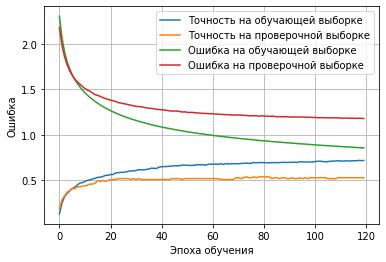

In [ ]:
chart(hisoryD2_5_37)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_5_37 = table(hisoryD2_5_37)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(Мел спектральные коэффициенты и частоты цветности)'] = ['2', '120', 'Adam', min(resultD2_5_37[0]), max(resultD2_5_37[1]), min(resultD2_5_37[2]), max(resultD2_5_37[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54


## Два Dense слоя (все, кроме частоты цветности)

In [ ]:
indexes_0_25 = range(0,25)

modelD2_0_25 = Sequential()
modelD2_0_25.add(Dense(200, activation='elu', input_shape=(len(indexes_0_25), )))
modelD2_0_25.add(Dense(10, activation='softmax'))

modelD2_0_25.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               5200      
_________________________________________________________________
dense_33 (Dense)             (None, 10)                2010      
Total params: 7,210
Trainable params: 7,210
Non-trainable params: 0
_________________________________________________________________





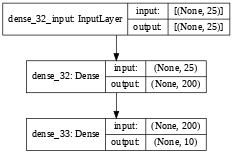

In [ ]:
showModel(modelD2_0_25)

### Обучение

In [ ]:
historyD2_0_25 = modelD2_0_25.fit(xTrain[:,indexes_0_25], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_0_25], yTest))

Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.1310 - accuracy: 0.2211 - val_loss: 1.9045 - val_accuracy: 0.3500
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9745 - accuracy: 0.3167 - val_loss: 1.7990 - val_accuracy: 0.3500
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8712 - accuracy: 0.3389 - val_loss: 1.7319 - val_accuracy: 0.3800
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7988 - accuracy: 0.3533 - val_loss: 1.6796 - val_accuracy: 0.4100
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7420 - accuracy: 0.3667 - val_loss: 1.6379 - val_accuracy: 0.4400
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6960 - accuracy: 0.3744 - val_loss: 1.6005 - val_accuracy: 0.4500
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6583 - accuracy: 0.3922 - val_loss: 1.5744 - val_accuracy: 0.4500
Epoch 8/120
4

### График

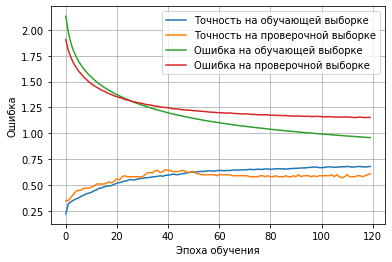

In [ ]:
chart(historyD2_0_25)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_0_25 = table(historyD2_0_25)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(все, кроме частоты цветности)'] = ['2', '120', 'Adam', min(resultD2_0_25[0]), max(resultD2_0_25[1]), min(resultD2_0_25[2]), max(resultD2_0_25[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65


## Два Dense слоя (все параметры, c шагом 2)

In [ ]:
indexes_37_2 = range(0,37,2)

modelD2_37_2 = Sequential()
modelD2_37_2.add(Dense(200, activation='elu', input_shape=(len(indexes_37_2), )))
modelD2_37_2.add(Dense(10, activation='softmax'))

modelD2_37_2.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 200)               4000      
_________________________________________________________________
dense_39 (Dense)             (None, 10)                2010      
Total params: 6,010
Trainable params: 6,010
Non-trainable params: 0
_________________________________________________________________





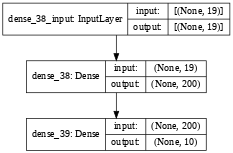

In [ ]:
showModel(modelD2_37_2)

### Обучение

In [ ]:
historyD2_37_2 = modelD2_37_2.fit(xTrain[:,indexes_37_2], yTrain, epochs=120, batch_size=20, validation_data=(xTest[:,indexes_37_2], yTest))

Epoch 1/120
45/45 [==============================] - 0s 5ms/step - loss: 2.2218 - accuracy: 0.1878 - val_loss: 2.1077 - val_accuracy: 0.2600
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 2.0532 - accuracy: 0.2767 - val_loss: 1.9673 - val_accuracy: 0.2900
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 1.9390 - accuracy: 0.3167 - val_loss: 1.8649 - val_accuracy: 0.3200
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 1.8552 - accuracy: 0.3400 - val_loss: 1.7957 - val_accuracy: 0.3600
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7922 - accuracy: 0.3567 - val_loss: 1.7431 - val_accuracy: 0.3600
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 1.7419 - accuracy: 0.3622 - val_loss: 1.6979 - val_accuracy: 0.3800
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 1.6987 - accuracy: 0.3878 - val_loss: 1.6595 - val_accuracy: 0.4000
Epoch 8/120
4

### График

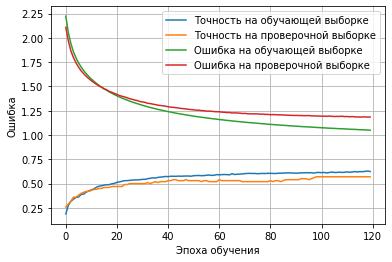

In [ ]:
chart(historyD2_37_2)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultD2_37_2 = table(historyD2_37_2)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(все, c шагом 2)'] = ['2', '120', 'Adam', min(resultD2_37_2[0]), max(resultD2_37_2[1]), min(resultD2_37_2[2]), max(resultD2_37_2[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57


# Преобразование данных и добавление в выборки

In [ ]:
# Квадрат значений
xTrain_sqr = np.array([[i**2 for i in x] for x in xTrain])
xTest_sqr  = np.array([[i**2 for i in x] for x in xTest])

# Квадратный корень из абсолютных значений
xTrain_sqrt = np.array([[sqrt(abs(i)) for i in x] for x in xTrain])
xTest_sqrt  = np.array([[sqrt(abs(i)) for i in x] for x in xTest])

# Обратное значение 1/i
xTrain_inv = np.array([[1/i for i in x] for x in xTrain])
xTest_inv  = np.array([[1/i for i in x] for x in xTest])

# 2 в степени i (значение)
xTrain_exp = np.array([[2**i for i in x] for x in xTrain])
xTest_exp  = np.array([[2**i for i in x] for x in xTest])

# Объединение всех массивов
xTrain_2 = np.hstack([xTrain, xTrain_sqr, xTrain_sqrt, xTrain_inv, xTrain_exp])
xTest_2 = np.hstack([xTest, xTest_sqr, xTest_sqrt, xTest_inv, xTest_exp])

# Посмотрим на получившиеся размеры
print(xTrain_2.shape)
print(xTest_2.shape)


(900, 185)
(100, 185)


In [ ]:
# Проверим что получилось. Например возьмем десятое значение
print(xTrain_2[10])

[ 2.00274656e+00  2.09774563e+00  2.26060452e+00  2.22454239e+00
  1.09627540e+00  8.51235605e-01 -1.73393219e+00  2.11028110e+00
 -1.23727437e+00  1.37439055e+00 -1.09439705e+00  1.25167778e+00
 -1.23012093e-01  1.55121961e+00  3.63082217e-02  5.52187206e-01
 -3.81615264e-01  6.28484521e-01 -3.49229471e-01  8.12270103e-01
 -4.32809355e-01  2.09940631e+00  8.59289755e-01  2.10639764e+00
  1.56862355e+00  5.60086257e-01  3.72861588e-02 -2.20064260e-01
  4.22147233e-01  1.14278483e-01  1.22033114e+00  4.68571459e-01
  1.02705565e+00  6.98218070e-01 -3.59934779e-01 -6.44330046e-02
 -2.78743672e-01  4.01099377e+00  4.40053671e+00  5.11033277e+00
  4.94858885e+00  1.20181974e+00  7.24602055e-01  3.00652084e+00
  4.45328632e+00  1.53084786e+00  1.88894939e+00  1.19770491e+00
  1.56669727e+00  1.51319750e-02  2.40628229e+00  1.31828696e-03
  3.04910710e-01  1.45630210e-01  3.94992794e-01  1.21961223e-01
  6.59782720e-01  1.87323938e-01  4.40750686e+00  7.38378883e-01
  4.43691101e+00  2.46057

## Нейронная сеть два Dense слоя

In [ ]:
model_2D = Sequential()
model_2D.add(Dense(200, activation='elu', input_shape=(xTrain_2.shape[1],)))
model_2D.add(Dense(10, activation='softmax'))

model_2D.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 200)               37200     
_________________________________________________________________
dense_45 (Dense)             (None, 10)                2010      
Total params: 39,210
Trainable params: 39,210
Non-trainable params: 0
_________________________________________________________________





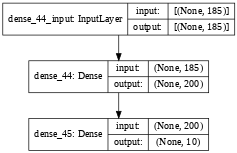

In [ ]:
showModel(model_2D)

### Обучение

In [ ]:
history_2D = model_2D.fit(xTrain_2, yTrain, epochs=120, batch_size=20, validation_data=(xTest_2, yTest))

Epoch 1/120
45/45 [==============================] - 1s 5ms/step - loss: 22.3721 - accuracy: 0.0944 - val_loss: 36.0396 - val_accuracy: 0.1100
Epoch 2/120
45/45 [==============================] - 0s 2ms/step - loss: 19.5282 - accuracy: 0.1178 - val_loss: 33.5072 - val_accuracy: 0.1700
Epoch 3/120
45/45 [==============================] - 0s 2ms/step - loss: 17.1144 - accuracy: 0.1611 - val_loss: 30.4578 - val_accuracy: 0.1700
Epoch 4/120
45/45 [==============================] - 0s 2ms/step - loss: 14.9031 - accuracy: 0.1944 - val_loss: 27.8574 - val_accuracy: 0.2400
Epoch 5/120
45/45 [==============================] - 0s 2ms/step - loss: 13.0310 - accuracy: 0.2289 - val_loss: 25.4104 - val_accuracy: 0.2500
Epoch 6/120
45/45 [==============================] - 0s 2ms/step - loss: 11.4161 - accuracy: 0.2489 - val_loss: 23.4771 - val_accuracy: 0.2600
Epoch 7/120
45/45 [==============================] - 0s 2ms/step - loss: 9.9002 - accuracy: 0.2833 - val_loss: 21.0317 - val_accuracy: 0.2800


### График

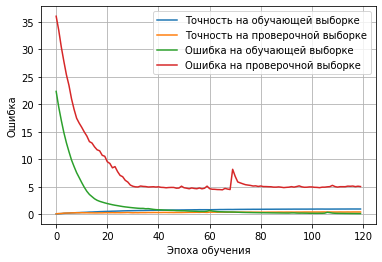

In [ ]:
chart(history_2D)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
result_2D = table(history_2D)

In [ ]:
# Заносим результат в таблицу
df.loc['Dense(с дополнительными значениями)'] = ['2', '120', 'Adam', min(result_2D[0]), max(result_2D[1]), min(result_2D[2]), max(result_2D[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(с дополнительными значениями),2,120,Adam,0.149612,0.988889,4.477334,0.45


# Нейронная сеть c Softmax

## 2 Ветви

In [ ]:
# Создание входного слоя 
input1 = Input((37,))
# Первая ветвь elu
x1 = Dense(10, activation='elu')(input1)
x1 = Dense(10, activation='elu')(x1)
# Вторая ветвь softmax
x2 = Dense(10, activation='elu')(input1)
x2 = Dense(40,activation='softmax')(x2)
# Объединение
x = concatenate([x1, x2])

x = Dense(10, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 10)           380         input_2[0][0]                    
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 10)           380         input_2[0][0]                    
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 10)           110         dense_52[0][0]                   
____________________________________________________________________________________________

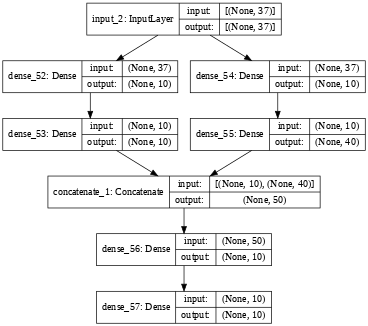

In [ ]:
showModel(model)

### Обучение

In [ ]:
historyC_2 = model.fit(xTrain, yTrain, epochs=600, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/600
45/45 [==============================] - 1s 6ms/step - loss: 2.3704 - accuracy: 0.0933 - val_loss: 2.3516 - val_accuracy: 0.0800
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3444 - accuracy: 0.1022 - val_loss: 2.3266 - val_accuracy: 0.0900
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3201 - accuracy: 0.1133 - val_loss: 2.3029 - val_accuracy: 0.1100
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2974 - accuracy: 0.1222 - val_loss: 2.2791 - val_accuracy: 0.1200
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2754 - accuracy: 0.1311 - val_loss: 2.2568 - val_accuracy: 0.1400
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2544 - accuracy: 0.1478 - val_loss: 2.2342 - val_accuracy: 0.1400
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2338 - accuracy: 0.1578 - val_loss: 2.2122 - val_accuracy: 0.1500
Epoch 8/600
4

### График

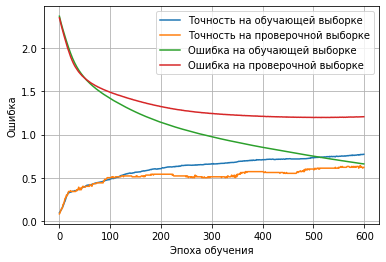

In [ ]:
chart(historyC_2)

### Дообучим сеть

In [ ]:
historyC_2 = model.fit(xTrain, yTrain, epochs=600, batch_size=20, validation_data=(xTest,yTest))

Epoch 1/600
45/45 [==============================] - 0s 3ms/step - loss: 0.6584 - accuracy: 0.7689 - val_loss: 1.2077 - val_accuracy: 0.6000
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.7722 - val_loss: 1.2066 - val_accuracy: 0.6100
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6567 - accuracy: 0.7700 - val_loss: 1.2069 - val_accuracy: 0.6100
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.7744 - val_loss: 1.2063 - val_accuracy: 0.6200
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6550 - accuracy: 0.7744 - val_loss: 1.2061 - val_accuracy: 0.6000
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6541 - accuracy: 0.7733 - val_loss: 1.2080 - val_accuracy: 0.6000
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.7722 - val_loss: 1.2069 - val_accuracy: 0.5800
Epoch 8/600
4

### График

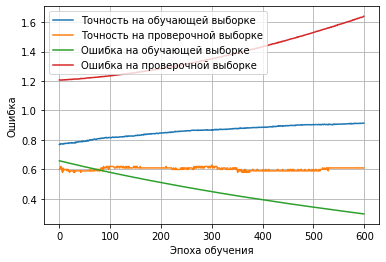

In [ ]:
chart(historyC_2)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultC_2 = table(historyC_2)

In [ ]:
# Заносим результат в таблицу
df.loc['2 Ветви elu/softmax'] = ['2', '600', 'Adam', min(resultC_2[0]), max(resultC_2[1]), min(resultC_2[2]), max(resultC_2[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(с дополнительными значениями),2,120,Adam,0.149612,0.988889,4.477334,0.45
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63


## 1 Ветвь

In [ ]:
input1 = Input((37,))

x1 = Dense(10, activation='elu')(input1)
x1 = Dense(10, activation='elu')(x1)

x = Dense(10, activation = 'elu')(x1)
x = Dense(10, activation = 'softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 37)]              0         
_________________________________________________________________
dense_62 (Dense)             (None, 10)                380       
_________________________________________________________________
dense_63 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_65 (Dense)             (None, 10)                110       
Total params: 710
Trainable params: 710
Non-trainable params: 0
_________________________________________________________________





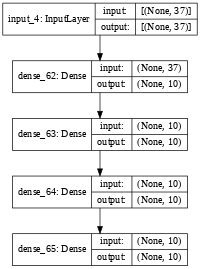

In [ ]:
showModel(model)

### Обучение

In [ ]:
historyC_1 = model.fit(xTrain,yTrain, epochs=600, batch_size=20, validation_data=(xTest, yTest))

Epoch 1/600
45/45 [==============================] - 1s 5ms/step - loss: 2.5108 - accuracy: 0.0911 - val_loss: 2.3373 - val_accuracy: 0.0600
Epoch 2/600
45/45 [==============================] - 0s 2ms/step - loss: 2.4593 - accuracy: 0.0989 - val_loss: 2.3010 - val_accuracy: 0.0600
Epoch 3/600
45/45 [==============================] - 0s 2ms/step - loss: 2.4156 - accuracy: 0.1033 - val_loss: 2.2687 - val_accuracy: 0.0600
Epoch 4/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3765 - accuracy: 0.1111 - val_loss: 2.2406 - val_accuracy: 0.0900
Epoch 5/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3421 - accuracy: 0.1222 - val_loss: 2.2155 - val_accuracy: 0.0900
Epoch 6/600
45/45 [==============================] - 0s 2ms/step - loss: 2.3109 - accuracy: 0.1333 - val_loss: 2.1917 - val_accuracy: 0.0900
Epoch 7/600
45/45 [==============================] - 0s 2ms/step - loss: 2.2826 - accuracy: 0.1467 - val_loss: 2.1704 - val_accuracy: 0.1100
Epoch 8/600
4

### График

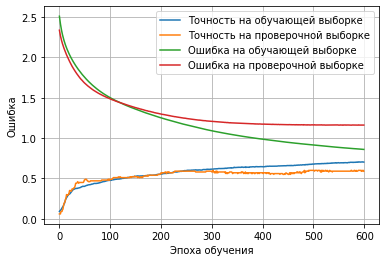

In [ ]:
chart(historyC_1)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultC_1 = table(historyC_1)

In [ ]:
# Заносим результат в таблицу
df.loc['1 Ветвь elu/softmax'] = ['2', '600', 'Adam', min(resultC_1[0]), max(resultC_1[1]), min(resultC_1[2]), max(resultC_1[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(с дополнительными значениями),2,120,Adam,0.149612,0.988889,4.477334,0.45
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63


## Сеть с 7 ветками

In [ ]:
indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dense(64, activation='elu')(input1)
x1 = Dense(64, activation='elu')(x1)

x2 = Dense(64, activation='elu')(input1)
x2 = Dense(40, activation='softmax')(x2)

x3 = Dense(64, activation='elu')(input1)
x3 = Dense(200, activation='softmax')(x3)

x4 = Dense(40, activation='softmax')(input1)

x5 = Dense(200, activation='softmax')(input1)

x6 = Dense(10, activation='softmax')(input1)

x7 = Dense(64, activation='elu')(input1)
x7 = Dense(10, activation='softmax')(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = Dense(64, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 64)           2432        input_5[0][0]                    
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 64)           2432        input_5[0][0]                    
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 64)           2432        input_5[0][0]                    
____________________________________________________________________________________________

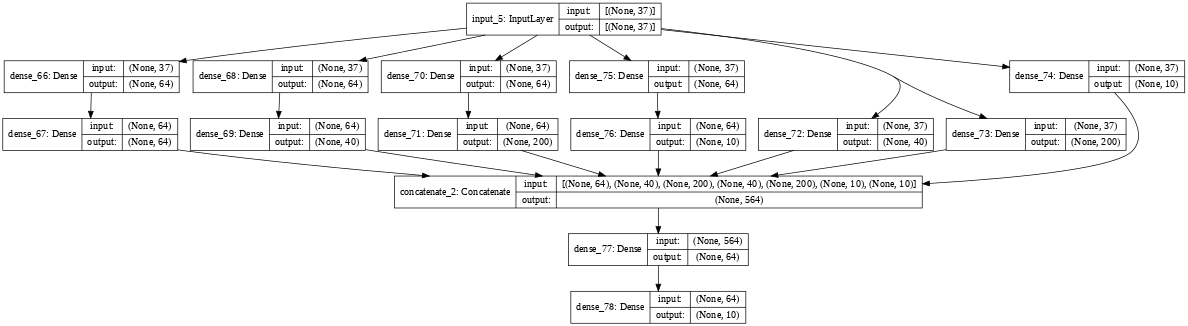

In [ ]:
showModel(model)

### Обучение

In [ ]:
historyC_7 = model.fit(xTrain[:,indexes],yTrain, epochs=1000, batch_size=20, validation_data=(xTest[:,indexes], yTest))

Epoch 1/1000
45/45 [==============================] - 1s 8ms/step - loss: 2.2472 - accuracy: 0.1533 - val_loss: 2.1516 - val_accuracy: 0.2400
Epoch 2/1000
45/45 [==============================] - 0s 4ms/step - loss: 2.0523 - accuracy: 0.3267 - val_loss: 1.9825 - val_accuracy: 0.3100
Epoch 3/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.9077 - accuracy: 0.3733 - val_loss: 1.8633 - val_accuracy: 0.3400
Epoch 4/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.7966 - accuracy: 0.3867 - val_loss: 1.7711 - val_accuracy: 0.3500
Epoch 5/1000
45/45 [==============================] - 0s 3ms/step - loss: 1.7106 - accuracy: 0.3967 - val_loss: 1.6989 - val_accuracy: 0.3800
Epoch 6/1000
45/45 [==============================] - 0s 3ms/step - loss: 1.6405 - accuracy: 0.4144 - val_loss: 1.6443 - val_accuracy: 0.4200
Epoch 7/1000
45/45 [==============================] - 0s 4ms/step - loss: 1.5810 - accuracy: 0.4344 - val_loss: 1.5949 - val_accuracy: 0.4400
Epoch 

### График

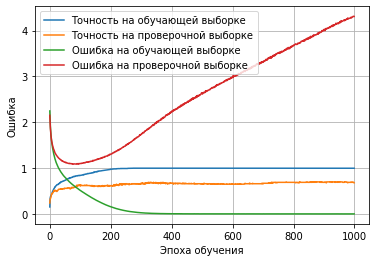

In [ ]:
chart(historyC_7)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultC_7 = table(historyC_7)

In [ ]:
# Заносим результат в таблицу
df.loc['7 Ветвей elu/softmax'] = ['7', '1000', 'Adam', min(resultC_7[0]), max(resultC_7[1]), min(resultC_7[2]), max(resultC_7[3])]

In [ ]:
# Посмотрим на результат
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(с дополнительными значениями),2,120,Adam,0.149612,0.988889,4.477334,0.45
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63


## 7 Ветвей с BatchNormalization

In [ ]:
indexes = range(0,37)

input1 = Input((len(indexes),))

x1 = Dense(256, activation='elu')(input1)
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation='softmax')(x1)
x1 = BatchNormalization()(x1)

x2 = Dense(256, activation='elu')(input1)
x2 = BatchNormalization()(x2)
x2 = Dense(40, activation='softmax')(x2)
x2 = BatchNormalization()(x2)

x3 = Dense(256, activation='elu')(input1)
x3 = BatchNormalization()(x3)
x3 = Dense(200, activation='softmax')(x3)
x3 = BatchNormalization()(x3)

x4 = Dense(40, activation='softmax')(input1)
x4 = BatchNormalization()(x4)

x5 = Dense(200, activation='softmax')(input1)
x5 = BatchNormalization()(x5)

x6 = Dense(10, activation='softmax')(input1)
x6 = BatchNormalization()(x6)

x7 = Dense(256, activation='elu')(input1)
x7 = BatchNormalization()(x7)
x7 = Dense(10, activation='softmax')(x7)
x7 = BatchNormalization()(x7)

x = concatenate([x1, x2, x3, x4, x5, x6, x7])

x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(10, activation='softmax')(x)

model = Model(input1, x)

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Вывод summary и схемы нейронной сети

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 64)           2432        input_5[0][0]                    
__________________________________________________________________________________________________
dense_68 (Dense)                (None, 64)           2432        input_5[0][0]                    
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 64)           2432        input_5[0][0]                    
____________________________________________________________________________________________

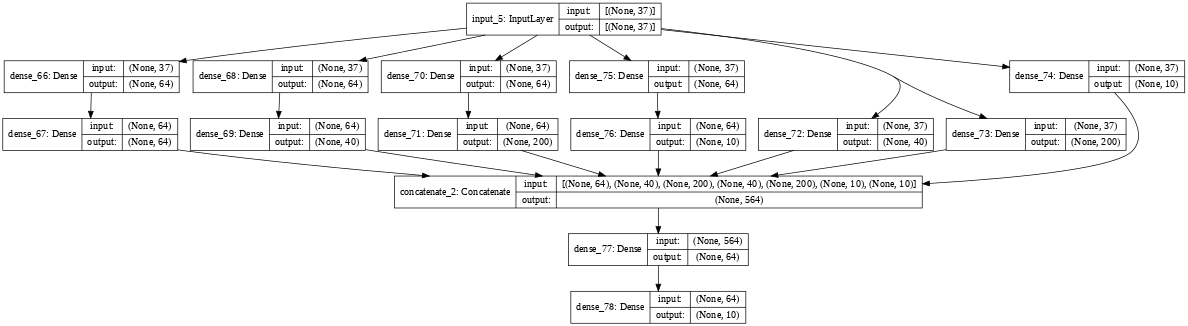

In [ ]:
showModel(model)

### Обучение

In [ ]:
historyC_7B = model.fit(xTrain[:,indexes],yTrain, epochs=1000, batch_size=20, validation_data=(xTest[:,indexes], yTest))

Epoch 1/1000
45/45 [==============================] - 5s 18ms/step - loss: 1.7838 - accuracy: 0.3833 - val_loss: 2.2955 - val_accuracy: 0.1300
Epoch 2/1000
45/45 [==============================] - 0s 10ms/step - loss: 1.2401 - accuracy: 0.5733 - val_loss: 2.2891 - val_accuracy: 0.1300
Epoch 3/1000
45/45 [==============================] - 0s 10ms/step - loss: 1.0368 - accuracy: 0.6633 - val_loss: 2.2663 - val_accuracy: 0.1500
Epoch 4/1000
45/45 [==============================] - 0s 10ms/step - loss: 0.9249 - accuracy: 0.7022 - val_loss: 2.2244 - val_accuracy: 0.2000
Epoch 5/1000
45/45 [==============================] - 0s 10ms/step - loss: 0.8455 - accuracy: 0.7178 - val_loss: 2.1650 - val_accuracy: 0.2100
Epoch 6/1000
45/45 [==============================] - 0s 10ms/step - loss: 0.7985 - accuracy: 0.7267 - val_loss: 2.0860 - val_accuracy: 0.2400
Epoch 7/1000
45/45 [==============================] - 0s 10ms/step - loss: 0.7071 - accuracy: 0.7667 - val_loss: 1.9648 - val_accuracy: 0.3300

### График

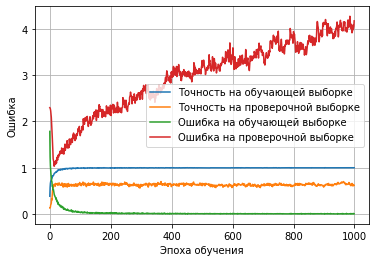

In [ ]:
chart(historyC_7B)

### Занесение в таблицу

In [ ]:
# C помощью функции получаем значения на последней эпохе
resultC_7B = table(historyC_7B)

In [ ]:
# Заносим результат в таблицу
df.loc['7 Ветвей elu/softmax c BatchNormalization'] = ['7', '1000', 'Adam', min(resultC_7B[0]), max(resultC_7B[1]), min(resultC_7B[2]), max(resultC_7B[3])]

# Распознавание выбранной песни

In [ ]:
# Выбираем песню 
songname = '/content/genres/rock/rock.00010.au'
y, sr = librosa.load(songname, mono=True, duration=30)

out = get_features(y, sr)

# Добавляем размероность
out = np.array(out).reshape(1,37)

# Нормализуем данные
out = scaler.transform(out)

In [ ]:
# Делаем predict
y = model.predict(out)

In [ ]:
# Выводим выход
print(y)
print()
# Распознаем класс
print("Предсказанный класс: ", np.argmax(y))
print()
# Проверяем ответ
print("Истинный класс: ", genres.index('rock'))

[[6.0892749e-17 1.5240579e-09 5.2039755e-09 1.2212328e-09 2.4379427e-09
  1.8930781e-12 2.5784848e-09 1.0000000e+00 3.1722816e-08 1.5845488e-09]]

Предсказанный класс:  7

Истинный класс:  7


# Общая таблица

In [ ]:
df

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
Dense(кроме Мел коэффициентов и частоты цветности),2,120,Adam,1.619606,0.400000,1.513992,0.51
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(только Частота цветности),2,120,Adam,1.677311,0.385556,1.760192,0.32
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(с дополнительными значениями),2,120,Adam,0.149612,0.988889,4.477334,0.45
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63


In [ ]:
# Сортируем таблицу по наибольшей точности на проверочной выборке
df.sort_values('val_accuracy', ascending=False)

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
7 Ветвей elu/softmax,7,1000,Adam,0.001549,0.998889,1.085459,0.70
7 Ветвей elu/softmax c BatchNormalization,7,1000,Adam,0.001247,1.000000,1.031583,0.70
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
1 Ветвь elu/softmax,2,600,Adam,0.859865,0.705556,1.159150,0.60
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54


In [ ]:
# Сортируем таблицу по наименьшей ошибки на проверочной выборке
df.sort_values('val_loss')

,Кол-во слоев,Кол-во эпох,Оптимайзер,loss,accuracy,val_loss,val_accuracy
Dense(Полные данные),5,200,RMSprop,0.029358,0.998889,1.005416,0.68
7 Ветвей elu/softmax c BatchNormalization,7,1000,Adam,0.001247,1.000000,1.031583,0.70
"Dense(Полные данные, 2 слоя)",2,120,Adam,0.779796,0.762222,1.081910,0.60
7 Ветвей elu/softmax,7,1000,Adam,0.001549,0.998889,1.085459,0.70
"Dense(все, кроме частоты цветности)",2,120,Adam,0.958408,0.680000,1.151472,0.65
1 Ветвь elu/softmax,2,600,Adam,0.859865,0.705556,1.159150,0.60
Dense(Мел спектральные коэффициенты и частоты цветности),2,120,Adam,0.857501,0.720000,1.180609,0.54
"Dense(все, c шагом 2)",2,120,Adam,1.049583,0.628889,1.183918,0.57
2 Ветви elu/softmax,2,600,Adam,0.297810,0.914444,1.206077,0.63
Dense(только Мел коэффициенты),2,120,Adam,1.052644,0.655556,1.246354,0.56


# Выводы:

1. Весь ноутбук писался в ручную, что дает большее понимание написанного кода.
2. Одной задаче может быть множество подходхов. Но как видно из таблицы, не всегда более сложный дает лучший результат.
3. Простая нейронная сеть с одними Dense слоями показала самую меньшую ошибку из всех.
4. Казалось бы, что увеличение входных данных должно увеличить точность распознавания, но на практике эта сеть покаказала самую большую ошибку на проверочной выборке.
5. Для увеличения точности нужно не только подбирать архитектуру сети и ее гиперпараметры, но и увеличивать обучающую выборку. 
6. Любую задачу нужно решать разными способами. Данная домашняя работа хорошая практика. 